# Notebook for visualizing Nextflow biohansel benchmarking trace info

Requires the following libraries to be installed:

- numpy
- scipy
- seaborn
- matplotlib
- pandas

Run the following command to install the required libraries for this notebook:

`pip install numpy scipy seaborn pandas matplotlib`

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
# set colorblind colour palette, see https://seaborn.pydata.org/tutorial/color_palettes.html#qualitative-color-palettes
sns.set_palette('colorblind', 10)


## Read in `trace.csv` file with trace info from running biohansel benchmarking workflow

In [3]:
df = pd.read_csv('trace.csv', index_col=0)

In [4]:
df.head()

,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,vmem,...,peak_vmem,peak_rss,vol_ctxt,inv_ctxt,scheme,samples,threads,type,iter,size_bytes
0,254714,16463,117261151481,92068200966,12014445,2821707,20956160,0,0,33693184,...,33902664,921740,608997,5955691,enteritidis_v1.0.7,96,16,multiple,1,96
1,194451,2967,5294021950,4363150182,595114,476897,33693696,2613248,6,9081096,...,9196388,1729740,124668,19804,enteritidis_v1.0.7,1,4,snippy,1,278310884
2,32065,1367,1196523488,929762999,122716,28508,20697088,0,0,2392860,...,2407628,70104,41924,23972,enteritidis_v1.0.7,1,1,single,8,257012787
3,248516,1781,4407836285,3817810257,528186,423290,33693696,2494464,6,8916344,...,9002448,1620880,119820,9708,enteritidis_v1.0.7,1,2,snippy,1,151868003
4,20675,1448,803832734,665249416,86501,20404,20697088,0,0,2393264,...,2407628,70144,32667,2917,enteritidis_v1.0.7,1,1,single,3,128835636


In [5]:
df.shape

(1596, 21)

What is RSS?
> In computing, resident set size is the portion of memory occupied by a process that is held in main memory

Convert `peak_rss` to MBytes and `realtime` to seconds

In [6]:
df.peak_rss = df.peak_rss / 1024

In [7]:
df.realtime = df.realtime / 1000

## Compare multithreaded biohansel vs grouped Snippy runtime metrics

- Snippy was run on one genome at a time with varying number of threads/CPUs (1,2,4,8,16,32) on a total of 96 genomes
- biohansel was run with 96 genomes with varying number of threads
- Snippy results need to be grouped to allow comparison (i.e. assume serial execution on 96 genomes with *N* threads)

In [8]:
dfsnippy = df.query('type == "snippy"')
dfsnippy.type = 'Snippy'

In [9]:
dfsnippy.head()

,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,vmem,...,peak_vmem,peak_rss,vol_ctxt,inv_ctxt,scheme,samples,threads,type,iter,size_bytes
1,194.451,2967,5294021950,4363150182,595114,476897,33693696,2613248,6,9081096,...,9196388,1689.199219,124668,19804,enteritidis_v1.0.7,1,4,Snippy,1,278310884
3,248.516,1781,4407836285,3817810257,528186,423290,33693696,2494464,6,8916344,...,9002448,1582.890625,119820,9708,enteritidis_v1.0.7,1,2,Snippy,1,151868003
5,342.125,1776,5649142051,4772435008,651218,517935,33728512,3031040,7,8850804,...,8983380,1869.371094,129343,14287,enteritidis_v1.0.7,1,2,Snippy,1,265953442
6,387.669,1899,4033921263,3262734719,455923,423733,33728512,2355200,4,8833524,...,8900564,1105.550781,85009,12593,enteritidis_v1.0.7,1,2,Snippy,1,346541347
7,88.444,6440,5840483012,4436552482,612872,485811,33693696,10207232,11,10069636,...,10170436,2876.121094,118538,1344,enteritidis_v1.0.7,1,32,Snippy,1,250503194


In [10]:
g_snippy = dfsnippy.groupby(by=['type','threads'])

For grouped Snippy results: 
- sum the runtime, # of characters read/written
- mean of the peak physical memory usage (RSS)

In [11]:
df_snippy = pd.DataFrame(dict(
    realtime=g_snippy.realtime.sum(),
    rchar=g_snippy.rchar.sum(),
    wchar=g_snippy.wchar.sum(),
    read_bytes=g_snippy.read_bytes.sum(),
    write_bytes=g_snippy.write_bytes.sum(),
    rss=g_snippy.rss.mean(),
    peak_rss=g_snippy.peak_rss.mean(),
    size_bytes=g_snippy.size_bytes.sum()))

In [12]:
df_snippy = df_snippy.reset_index()

In [13]:
df_snippy.size_bytes.unique()[0] / 1024**2

24016.67756843567

In [14]:
df_bh_m = df.query('type == "multiple"')

In [15]:
df_bh_m.type = "BioHansel"

In [16]:
dfm = pd.concat([df_bh_m, df_snippy], sort=False)

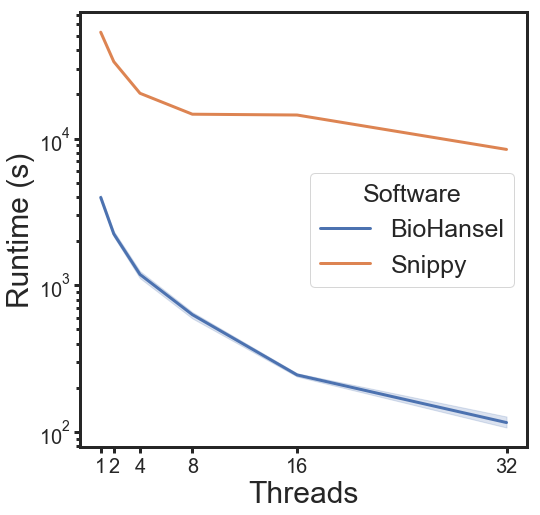

In [19]:
sns.set(style="ticks", rc={"font.size":25,"axes.titlesize":30,"axes.labelsize":30,"lines.linewidth":3,"axes.linewidth":3, "xtick.major.width":3,"ytick.major.width":3, "ytick.minor.width":3 })
fig, ax = plt.subplots(figsize=(8,8))

ax.set_yscale('log')

sns.lineplot(x='threads', y='realtime',hue='type', data=dfm)
ax.legend(['BioHansel', 'Snippy'], title='Software', fontsize=25)
ax.set(ylabel='Runtime (s)')
ax.set(xlabel='Threads')
ax.set_xticks(dfm.threads.unique())
ax.tick_params(labelsize=20)

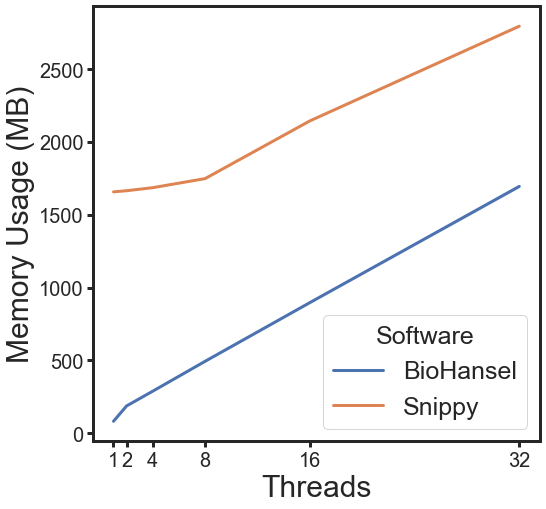

In [21]:
sns.set(style="ticks", rc={"font.size":25,"axes.titlesize":30,"axes.labelsize":30,"lines.linewidth":3,"axes.linewidth":3, "xtick.major.width":3,"ytick.major.width":3, "ytick.minor.width":3 })
fig, ax = plt.subplots(figsize=(8,8))


# ax.set_yscale('log')

sns.lineplot(x='threads', y='peak_rss',hue='type', data=dfm)
ax.legend(['BioHansel', 'Snippy'], title='Software', fontsize=25)
ax.set(ylabel='Memory Usage (MB)')
ax.set(xlabel='Threads')
ax.set_xticks(dfm.threads.unique())
ax.tick_params(labelsize=20)

## Runtime vs input file size - single core

Highlighting different schemes.

In [22]:
dfs = df.query('(type == "single" or type == "snippy") and threads == 1')
dfs.loc[dfs.type == 'single', 'type'] = 'BioHansel'
dfs.loc[dfs.type == 'snippy', 'type'] = 'Snippy'

In [23]:
dfs.head()

,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,vmem,...,peak_vmem,peak_rss,vol_ctxt,inv_ctxt,scheme,samples,threads,type,iter,size_bytes
2,32.065,1367,1196523488,929762999,122716,28508,20697088,0,0,2392860,...,2407628,68.460938,41924,23972,enteritidis_v1.0.7,1,1,BioHansel,8,257012787
4,20.675,1448,803832734,665249416,86501,20404,20697088,0,0,2393264,...,2407628,68.500000,32667,2917,enteritidis_v1.0.7,1,1,BioHansel,3,128835636
8,29.004,1475,1196523489,929762999,122732,28508,20697088,0,0,2387256,...,2407628,68.566406,41730,8214,enteritidis_v1.0.7,1,1,BioHansel,9,257012787
9,32.363,1493,1490836615,1145404768,151440,35115,20697088,0,0,2396388,...,2407628,68.675781,52264,5562,enteritidis_v1.0.7,1,1,BioHansel,1,335684179
10,34.952,1257,1198872125,943622189,124074,28934,20697088,0,0,2382356,...,2407624,68.371094,45176,36639,enteritidis_v1.0.7,1,1,BioHansel,10,245502220


In [24]:
dfs.shape

(1056, 21)

In [25]:
dfs['size_MB'] = dfs.size_bytes / (1024**2)

In [26]:
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

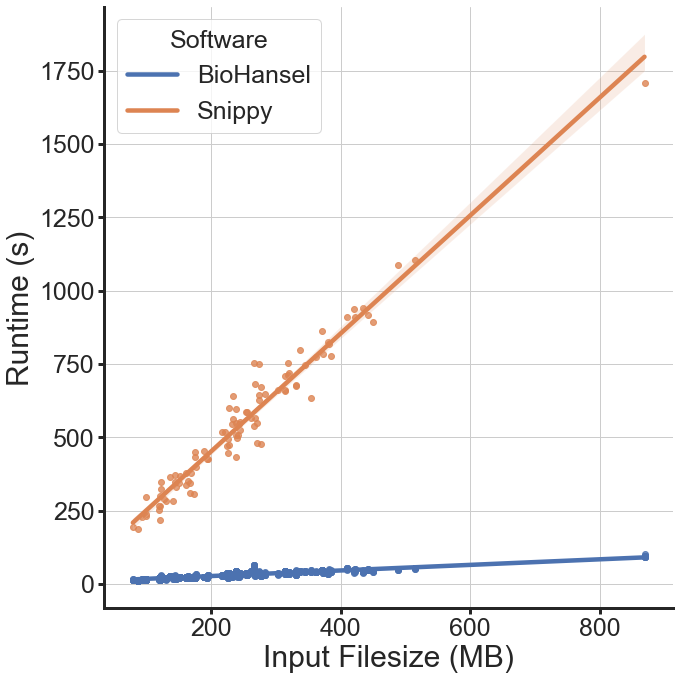

In [27]:
grid = sns.lmplot(y='realtime', x='size_MB', hue='type', data=dfs, legend=False, height=10, truncate=True)
grid.ax.set(xlabel='Input Filesize (MB)')
grid.ax.set(ylabel='Runtime (s)')
grid.ax.xaxis.grid(True)
grid.ax.yaxis.grid(True)
grid.ax.legend(['BioHansel', 'Snippy'], title='Software')

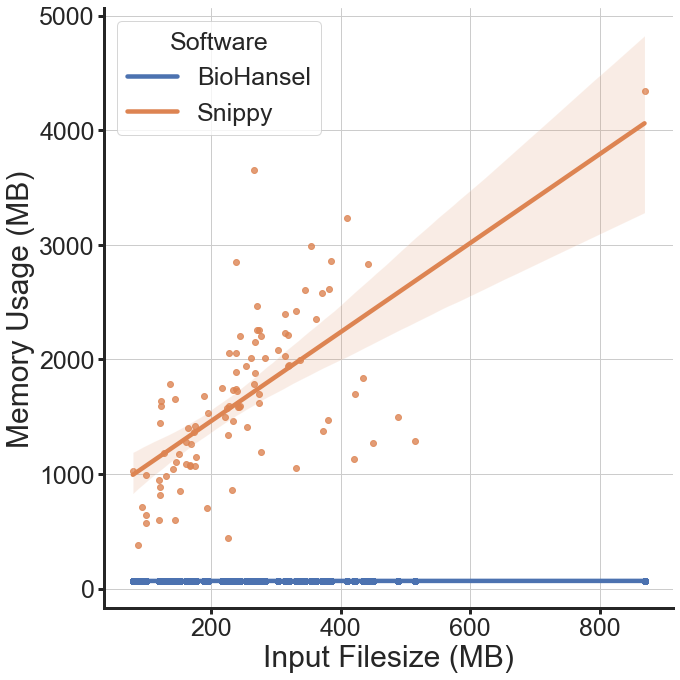

In [28]:
grid = sns.lmplot(y='peak_rss', x='size_MB', hue='type', data=dfs, legend=False, height=10, truncate=True)
grid.ax.set(xlabel='Input Filesize (MB)')
grid.ax.set(ylabel='Memory Usage (MB)')
grid.ax.xaxis.grid(True)
grid.ax.yaxis.grid(True)
grid.ax.legend(['BioHansel', 'Snippy'], title='Software')
